In [21]:
# modules we'll use

import os
import re  # For preprocessing
import pandas as pd  # For data handling
import spacy
import logging  # Setting up the loggings to monitor gensim
import multiprocessing
import gensim
import seaborn as sns

from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

In [22]:
from plotting.t_sne_scatter_plotter import TSNEScatterPlotter
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [23]:
#mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [24]:
# read in all our data
# Google Drive's path: /content/drive/MyDrive/Praca Inżynierska/kickstarter/data/spotify.csv
spotify_orig  = pd.read_csv("../data/spotify.csv")

In [25]:
# look at a few rows of the ks_projects file
spotify_orig.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
20364,0.559,1928,0.993,"['Wolfgang Amadeus Mozart', 'Vladimir Horowitz']",0.493,220173,0.0842,0,0Xu0gdLfgEiKXdpHcrYiRh,0.879000,9,0.1120,-24.255,1,"Piano Sonata No. 11 in A Major, K. 331: III. R...",0,1928,0.0518,122.532
145290,0.823,1968,0.488,['Vince Guaraldi'],0.403,160173,0.6180,0,2rSuv0WVuyJUI4fFXuSS19,0.000126,10,0.1570,-11.932,1,Peppermint Patty,17,1968,0.0299,137.739
16232,0.807,2003,0.151,['The Proclaimers'],0.851,219467,0.5510,0,66S14BkJDxgkYxLl5DCqOz,0.000000,4,0.0827,-5.177,1,I'm Gonna Be (500 Miles),74,2003-09-01,0.0396,131.922
118459,0.195,1988,0.158,['Ministry'],0.716,312307,0.9460,0,6W7ngPDxXx5fXrYwiKWN51,0.002610,7,0.3330,-10.707,0,The Land of Rape and Honey,32,1988,0.0383,105.415
69739,0.685,1993,0.169,['Liberación'],0.606,177840,0.6280,0,2Fl2oyP6AiYriQfP9lcASP,0.000000,1,0.1190,-8.841,0,A Esa,42,1993-01-01,0.0394,93.227


In [26]:
# get info about DataFrame columns
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [27]:
# count nullable words
spotify_orig.isnull().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

In [28]:
# Cleaning
# We are lemmatizing and removing the stopwords and non-alphabetic characters for each line

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

# Removes non-alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in spotify_orig['name'])

In [29]:
# Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.01 mins


In [30]:
# Put the results in a DataFrame to remove missing values and duplicates:

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(60810, 1)

In [31]:
df_clean.head()

,clean
0,piano concerto d minor op iii finale alla breve
1,clancy lower boom
4,irish eye smile
7,morceaux de fantaisie op pr lude c sharp minor...
8,la ma anita remasterizado


In [32]:
# Bigrams:
# We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
# https://radimrehurek.com/gensim/models/phrases.html
# The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

# As Phrases() takes a list of list of words as input:
sent = [row.split() for row in df_clean['clean']]
# Creates the relevant phrases from the list of sentences:
phrases = Phrases(sent, min_count=30, progress_per=10000)
# The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed
# for the bigram detection task:
bigram = Phraser(phrases)
# Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

INFO - 17:06:59: collecting all words and their counts
INFO - 17:06:59: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:06:59: PROGRESS: at sentence #10000, processed 45240 words and 35105 word types
INFO - 17:06:59: PROGRESS: at sentence #20000, processed 91184 words and 61256 word types
INFO - 17:06:59: PROGRESS: at sentence #30000, processed 141146 words and 88638 word types
INFO - 17:06:59: PROGRESS: at sentence #40000, processed 187938 words and 111136 word types
INFO - 17:06:59: PROGRESS: at sentence #50000, processed 237353 words and 133971 word types
INFO - 17:06:59: PROGRESS: at sentence #60000, processed 285814 words and 155533 word types
INFO - 17:06:59: collected 157230 word types from a corpus of 289358 words (unigram + bigrams) and 60810 sentences
INFO - 17:06:59: using 157230 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 17:06:59: source_vocab length 157230
INFO - 17:07:01: Phraser built with 254 

In [33]:
# Most Frequent Words:
# Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['live',
 'remastere',
 'feat',
 "'",
 'de',
 'remaster',
 'version',
 'la',
 'love',
 'op']

In [34]:
# Training the model
# Gensim Word2Vec Implementation:
# We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

# I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
#
# Word2Vec():
# In this first step, I set up the parameters of the model one-by-one.
# I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.
#
# .build_vocab():
# Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
# With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus.
# I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model.
# Displaying both allows for a more accurate and an easier management of their influence.
#
# .train():
# Finally, trains the model.
# The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [35]:
# The parameters:
# min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
# window = int - The maximum distance between the current and predicted word within a sentence.
# E.g. window words on the left and window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency words are randomly downsampled.
# Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses.
# To set it: alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words"
# should be drown. If set to 0, no negative sampling is used. - (5, 20)
# workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [36]:
# Building the Vocabulary Table:
# Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words,
# and doing some basic counts on them):

t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:07:02: collecting all words and their counts
INFO - 17:07:02: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:07:02: PROGRESS: at sentence #10000, processed 42265 words, keeping 10912 word types
INFO - 17:07:03: PROGRESS: at sentence #20000, processed 85033 words, keeping 16910 word types
INFO - 17:07:03: PROGRESS: at sentence #30000, processed 131462 words, keeping 23061 word types
INFO - 17:07:03: PROGRESS: at sentence #40000, processed 175354 words, keeping 27428 word types
INFO - 17:07:03: PROGRESS: at sentence #50000, processed 221683 words, keeping 31802 word types
INFO - 17:07:03: PROGRESS: at sentence #60000, processed 267465 words, keeping 35661 word types
INFO - 17:07:03: collected 35962 word types from a corpus of 270875 raw words and 60810 sentences
INFO - 17:07:03: Loading a fresh vocabulary
INFO - 17:07:03: min_count=20 retains 2074 unique words (5% of original 35962, drops 33888)
INFO - 17:07:03: min_count=20 leaves 184166 word corpu

Time to build vocab: 0.03 mins


In [37]:
# Training of the model:

# Parameters of the training:
# total_examples = int - Count of sentences;
# epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:07:04: training model with 7 workers on 2074 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 17:07:05: worker thread finished; awaiting finish of 6 more threads
INFO - 17:07:05: worker thread finished; awaiting finish of 5 more threads
INFO - 17:07:05: worker thread finished; awaiting finish of 4 more threads
INFO - 17:07:05: worker thread finished; awaiting finish of 3 more threads
INFO - 17:07:05: worker thread finished; awaiting finish of 2 more threads
INFO - 17:07:05: EPOCH 1 - PROGRESS: at 96.07% examples, 71382 words/s, in_qsize 1, out_qsize 1
INFO - 17:07:05: worker thread finished; awaiting finish of 1 more threads
INFO - 17:07:05: worker thread finished; awaiting finish of 0 more threads
INFO - 17:07:05: EPOCH - 1 : training on 270875 raw words (75138 effective words) took 1.0s, 73331 effective words/s
INFO - 17:07:06: EPOCH 2 - PROGRESS: at 92.44% examples, 67965 words/s, in_qsize 0, out_qsize 0
INFO - 17:07:06: worker thread f

Time to train the model: 0.54 mins


In [38]:
# As we do not plan to train the model any further, we are calling init_sims(),
# which will make the model much more memory-efficient:
w2v_model.init_sims(replace=True)

INFO - 17:07:36: precomputing L2-norms of word weight vectors


In [39]:
# create file
cwd = os.getcwd()
filename = os.path.join(cwd, 'data\\spotify_track_names_embedding.bin')
open(filename, 'w').close()

# save model to binary file
w2v_model.wv.save_word2vec_format(filename, binary=True)

INFO - 17:07:37: storing 2074x300 projection weights into C:\Users\micha\Praca inżynierska PJATK\kickstarter\notebooks\data\spotify_track_names_embedding.bin


In [40]:
# Exploring the model
# Most similar to:
# Here, we will ask our model to find the word most similar to 'love'

w2v_model.wv.most_similar(positive=["love"])

[('everybody', 0.9742722511291504),
 ('good', 0.9725136756896973),
 ('thing', 0.9722975492477417),
 ('like', 0.9711258411407471),
 ('wanna', 0.9698383212089539),
 ('laugh', 0.9686394929885864),
 ('know', 0.9676110744476318),
 ('need', 0.96620774269104),
 ('will', 0.9654269814491272),
 ('look', 0.964455783367157)]

In [41]:
# Similarities:
# Here, we will see how similar are two words to each other :

w2v_model.wv.similarity('love', 'like')

0.9711258538572081

In [42]:
w2v_model.wv.similarity('love', 'wood')

# Odd-One-Out:
# Here, we ask our model to give us the word that does not belong to the list!

w2v_model.wv.doesnt_match(['love', 'like', 'tree'])

C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'tree'

In [43]:
w2v_model.wv.doesnt_match(['moon', 'plant', 'rose'])

WARNING - 17:07:37: vectors for words {'plant'} are not present in the model, ignoring these words


'moon'

In [44]:
# Analogy difference:

# Which word is to woman as homer is to marge?

w2v_model.wv.most_similar(positive=["cold", "hate"], negative=["love"], topn=3)
w2v_model.wv.most_similar(positive=["joy", "door"], negative=["house"], topn=3)

[('tune', 0.7786297798156738),
 ('gham', 0.7776765823364258),
 ('mor', 0.7746872901916504)]

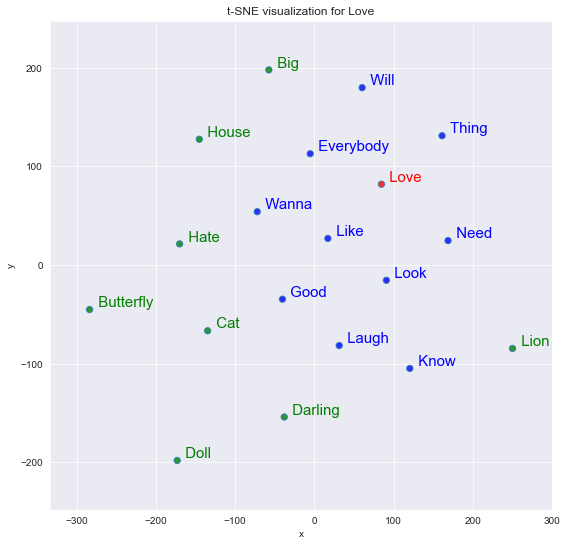

In [45]:
# 10 Most similar words vs. 8 Random words:
# Let's compare where the vector representation of 'love', its 10 most similar words from the model, ' \
# 'as well as 8 random ones, lies in a 2D graph:

%matplotlib inline

plotter = TSNEScatterPlotter(w2v_model)

plotter.plot('love', ['darling', 'hate', 'house', 'cat', 'butterfly', 'lion', 'big', 'doll'])

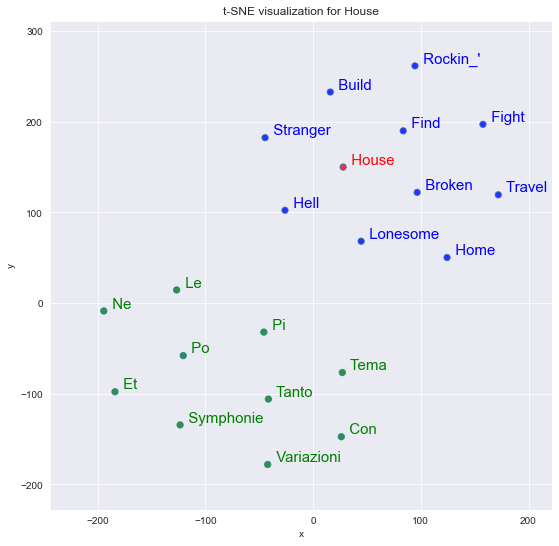

In [46]:
# 10 Most similar words vs. 10 Most dissimilar
# This time, let's compare where the vector representation of 'house' and her 10 most similar words from the model lies
# compare to the vector representation of the 10 most dissimilar words to 'house':

plotter.plot('house', [i[0] for i in w2v_model.wv.most_similar(negative=["house"])])